# Analysis tools

## Load data
Make sure METCOMP_utils.py is located in the same directory as the notebook.

This requires that, for both the reference and MESAN datasets, the data is divided into .csv -files for each day containing 24 rows corresponding to each hour. For one of these datasets, the .csv -files are located in a folder corresponding to the station. This folder is located within a master folder containing the entire dataset.

For example, a MESAN dataset containing three stations with 100 days of collected data each is structured with the master folder MESAN_CSV. Within MESAN_CSV we find folders for each station 1, 2 and 3. Within these folders there exists 100 .csv -files, one for each day.

Dont forget any eventual unit conversions. The scripts operate on a SMHI unit convention found at http://opendata.smhi.se/apidocs/metanalys/parameters.html

In [105]:
from METCOMP_utils import *
# Define time interval.
start_date = datetime.date(2019, 1, 1)
end_date = datetime.date(2019, 12, 31)

# Load interpolated data.
df_MESAN = read_CSV('40010', 'MESAN', start_date, end_date)
# Load reference observations.
df_REF = get_LANTMET('40010', start_date, end_date)

# Unit conversion if needed.
df_REF['UM'] = df_REF['UM']/100 # LantMet relative humidity in [0, 100]. Rescale to [0, 1] to follow SMHI convention.


## Error distribution per month
Plot histograms of the errors for each month. Set paramater and bin_width.

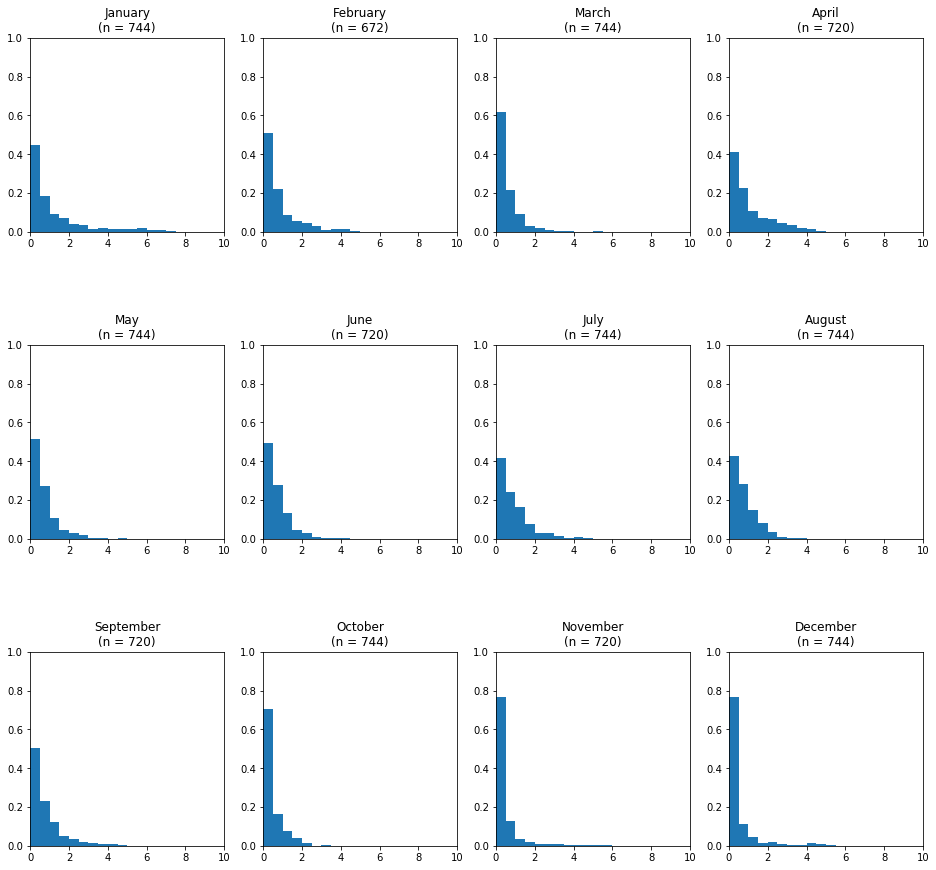

In [111]:
import matplotlib.pyplot as plt
import numpy as np

# === SETTINGS ======================================================================================
# Choose parameter of interest. (SMHI convention)
param = 't'
# bin_width: Width of histogram bins.
bin_width = 0.5
# param_dict: Dictionary translating SMHI parameter names to corresponding parameters in reference.
#             Example: param_dict = {'t': 'ref_temperature', 'prec1h': 'ref_precipitation', ...}
param_dict = {'t': 'TM', 'prec1h': 'RR', 'r': 'UM', 'ws': 'FM2'}
# ===================================================================================================


# Construct error dataframe.
timestamps = df_MESAN['Timestamp']
errors = abs(df_MESAN[param] - df_REF[param_dict[param]])
df_ERROR = pd.DataFrame.from_dict({'Timestamp': timestamps, 'Error': errors})


ERROR_months = divide_months(df_ERROR)


rows = 3
cols = 4
fig, axs = plt.subplots(rows, cols, figsize = (16, 16))
bins = np.arange(min(df_ERROR['Error']), max(df_ERROR['Error']) + bin_width, bin_width)
month = 1
for row in range(0, rows):
    for col in range(0, cols):
        
        # Get month string. Pad with '0' ahead if single integer.
        month_str = ''
        if month < 10:
            month_str = '0' + str(month)
        else:
            month_str = str(month)
        # Get month name.
        tmp_date = datetime.datetime.strptime('2020-' + month_str + '-01', '%Y-%m-%d').date()
        month_name = tmp_date.strftime('%B')
        
        
        weights = np.ones_like(ERROR_months[month]['Error'])/float(len(ERROR_months[month]['Error']))
        axs[row, col].hist(ERROR_months[month]['Error'], bins=bins, weights=weights)
        
        axs[row, col].set_xlim([0, max(bins)])
        axs[row, col].set_ylim([0, 1])
        x0,x1 = axs[row, col].get_xlim()
        y0,y1 = axs[row, col].get_ylim()
        axs[row, col].set_aspect(abs(x1-x0)/abs(y1-y0))
        
        n = ERROR_months[month].shape[0]
        axs[row, col].title.set_text(month_name + '\n(n = ' + str(n) + ')' )
        
        month = month + 1
        
        


## Avarage daily error variation per month
Plot avarage daily error for each month with min and max values for each hour. Choose a parameter of interest.

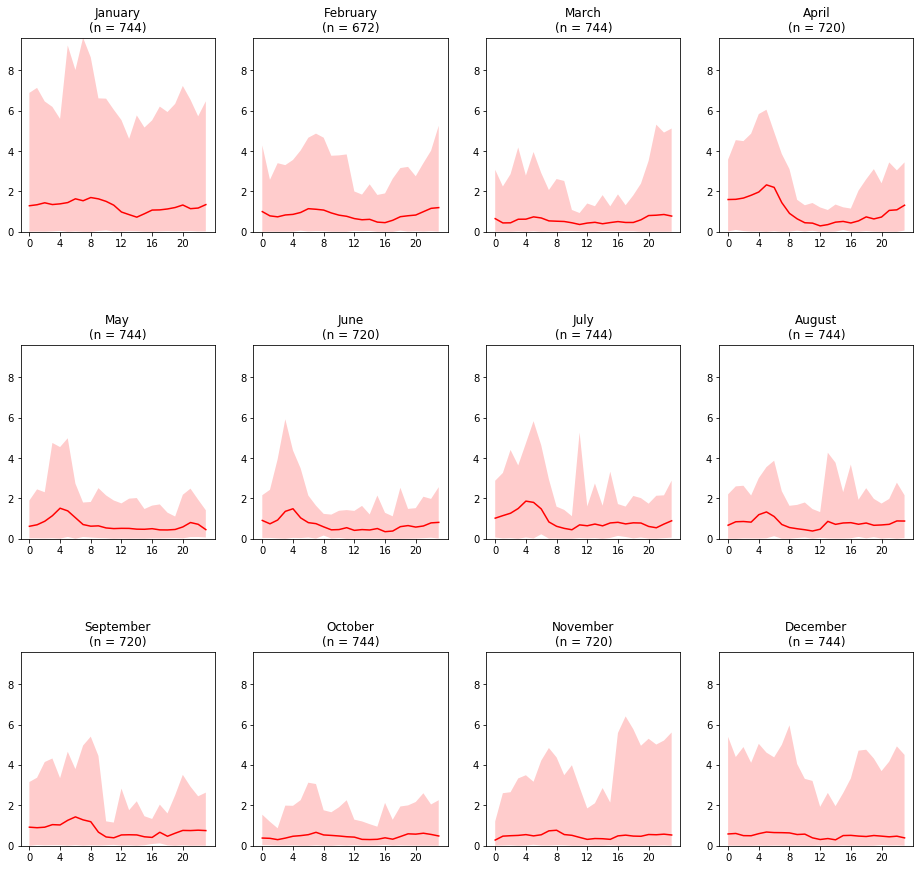

In [107]:
import matplotlib.pyplot as plt
import numpy as np

# === SETTINGS ======================================================================================
# Choose parameter of interest. (MESAN convention)
param = 't'
# param_dict: Dictionary translating SMHI parameter names to corresponding parameters in reference.
#             Example: param_dict = {'t': 'ref_temperature', 'prec1h': 'ref_precipitation', ...}
param_dict = {'t': 'TM', 'prec1h': 'RR', 'r': 'UM', 'ws': 'FM2'}
# ===================================================================================================


# Construct error dataframe.
timestamps = df_MESAN['Timestamp']
errors = abs(df_MESAN[param] - df_REF[param_dict[param]])
df_ERROR = pd.DataFrame.from_dict({'Timestamp': timestamps, 'Error': errors})


ERROR_months = divide_months(df_ERROR)

limits = [min(df_ERROR['Error']), max(df_ERROR['Error'])]
rows = 3
cols = 4
fig, axs = plt.subplots(rows, cols, figsize = (16, 16))
month = 1
for row in range(0, rows):
    for col in range(0, cols):
        
        # Get month string. Pad with '0' ahead if single integer.
        month_str = ''
        if month < 10:
            month_str = '0' + str(month)
        else:
            month_str = str(month)
        # Get month name.
        tmp_date = datetime.datetime.strptime('2020-' + month_str + '-01', '%Y-%m-%d').date()
        month_name = tmp_date.strftime('%B')
        
        # Get monthly avarage, min and max errors.
        avg_day_error = []
        min_day_error = []
        max_day_error = []
        ERROR_hours = divide_hours(ERROR_months[month])
        hours = [i for i in range(0, 24)]
        for hour in hours:
            avg_day_error.append(ERROR_hours[hour]['Error'].mean(skipna=True))
            min_day_error.append(ERROR_hours[hour]['Error'].min(skipna=True))
            max_day_error.append(ERROR_hours[hour]['Error'].max(skipna=True))
        
        # Plot figures
        axs[row, col].fill_between(hours, min_day_error, max_day_error, facecolor='r', alpha=0.2)
        axs[row, col].plot(hours, avg_day_error, 'r')  
        axs[row, col].set_xticks(np.arange(min(hours), max(hours)+1, 4.0))
        axs[row, col].set_ylim(limits)
        
        # Set aspect ratios
        x0,x1 = axs[row, col].get_xlim()
        y0,y1 = axs[row, col].get_ylim()
        axs[row, col].set_aspect(abs(x1-x0)/abs(y1-y0))
        
        # Set title.
        n = ERROR_months[month].shape[0]
        axs[row, col].title.set_text(month_name + '\n(n = ' + str(n) + ')' )
        
        month = month + 1

## Parameter correlation
Plot correlation of each parameter defined in param_dict and their corresponding pearson correlation coefficient.

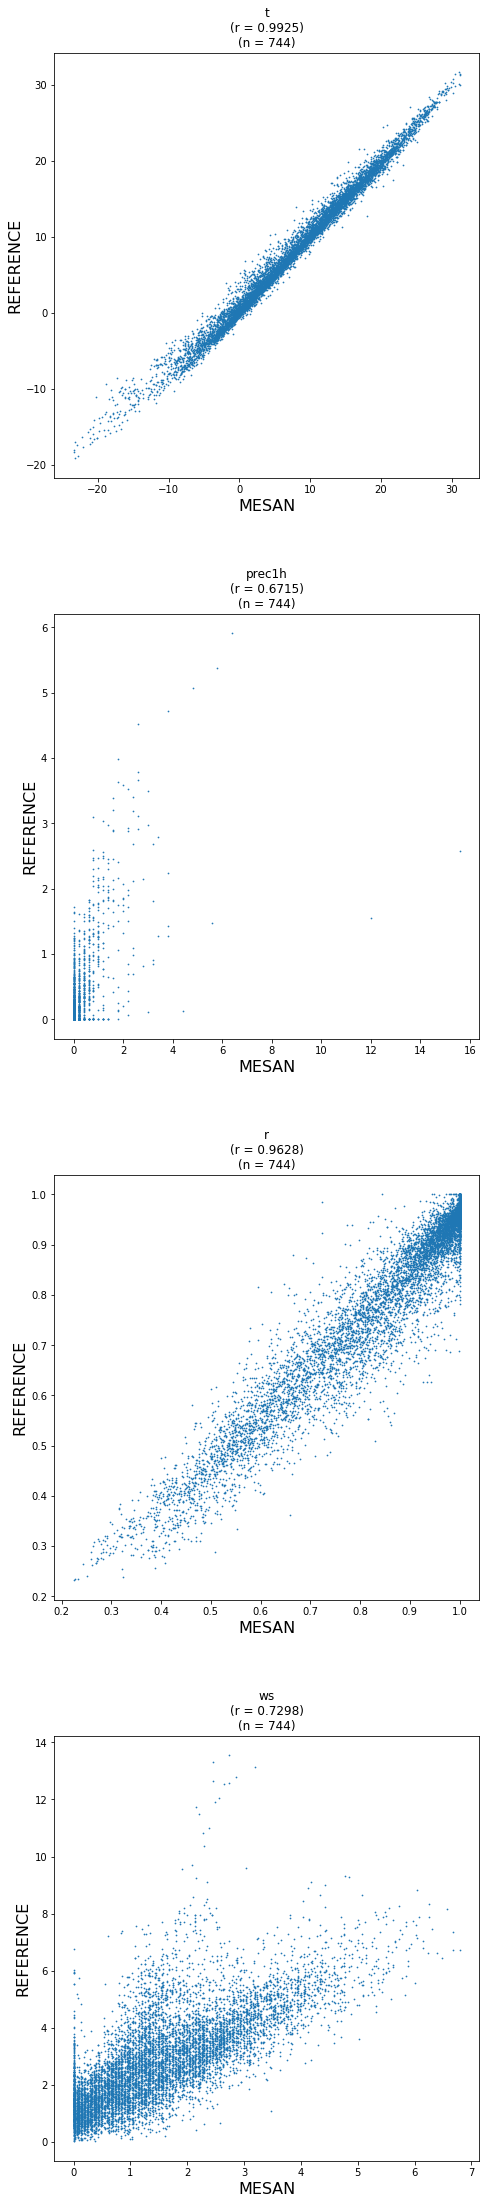

In [108]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# === SETTINGS ======================================================================================
# param_dict: Dictionary translating SMHI parameter names to corresponding parameters in reference.
#             Example: param_dict = {'t': 'ref_temperature', 'prec1h': 'ref_precipitation', ...}
param_dict = {'t': 'TM', 'prec1h': 'RR', 'r': 'UM', 'ws': 'FM2'}
# ===================================================================================================

N = len(param_dict)
fig, axs = plt.subplots(N, 1, figsize=(8, 8*N))
fig.tight_layout(pad=6.0)
index = 0
for param in param_dict:
    
    r = round(pearsonr(df_REF[param_dict[param]], df_MESAN[param])[0], 4)
    
    axs[index].scatter(df_REF[param_dict[param]], df_MESAN[param], s=0.5)
    axs[index].set_xlabel('MESAN', fontsize=16)
    axs[index].set_ylabel('REFERENCE', fontsize=16)
    
    # Set aspects.
    x0,x1 = axs[index].get_xlim()
    y0,y1 = axs[index].get_ylim()
    axs[index].set_aspect(abs(x1-x0)/abs(y1-y0))
        
    # Set subplot title to month name and include pearson correlation coefficient.
    axs[index].title.set_text(param + '\n(r = ' + str(r) + ')\n(n = ' + str(n) + ')' )
    
    index = index + 1


## Error threshold plot
Plot the sorted error and choose a threshold. Through this, the expected maximum error can be found for threshold fraction of the samples.

As an example, if we require that the error are less than 1 degree for the temperature in 90 % of the samples, we set threshold to 0.9 and observe the threshold error. If this is below the requirements, MESAN data may be suitable to use for temperature.

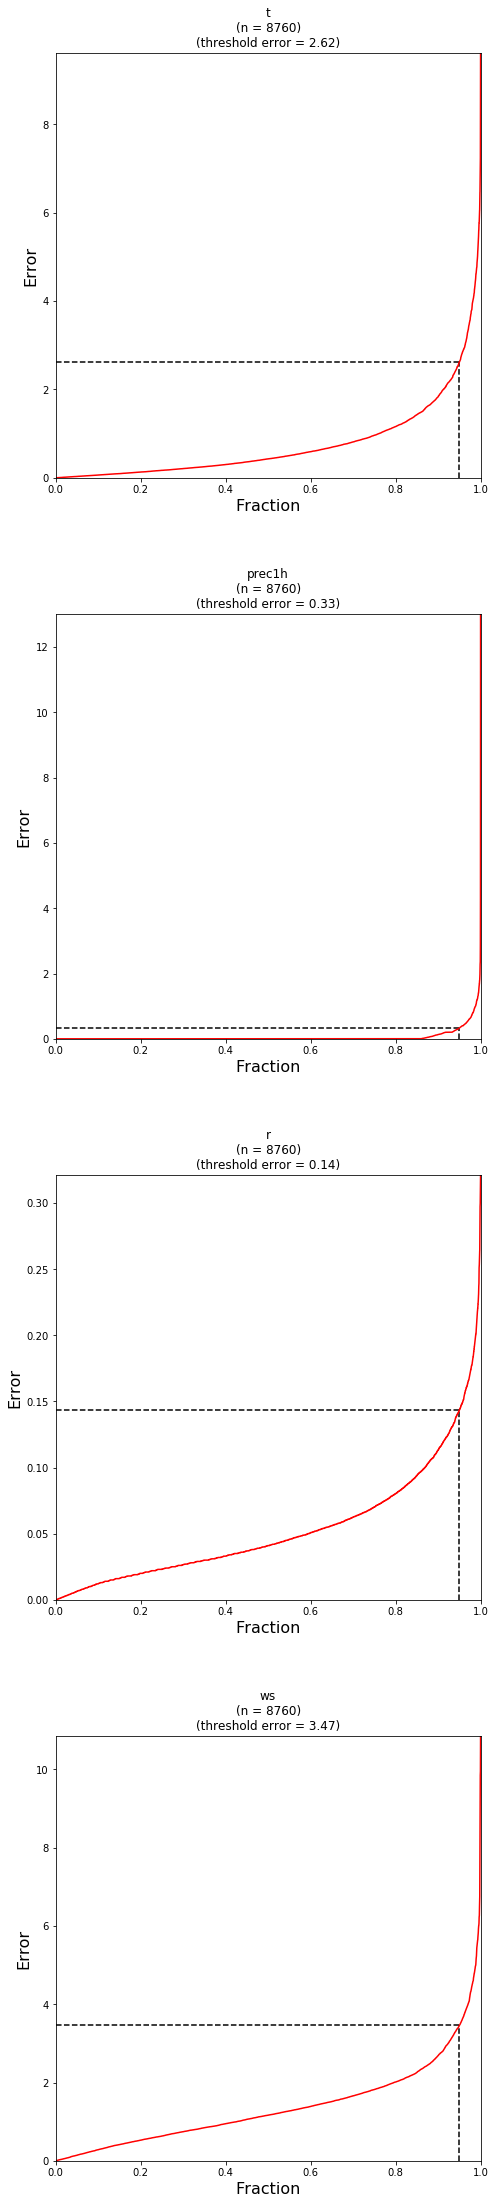

In [109]:
import matplotlib.pyplot as plt
import numpy as np

# === SETTINGS ======================================================================================
# param_dict: Dictionary translating SMHI parameter names to corresponding parameters in reference.
#             Example: param_dict = {'t': 'ref_temperature', 'prec1h': 'ref_precipitation', ...}
param_dict = {'t': 'TM', 'prec1h': 'RR', 'r': 'UM', 'ws': 'FM2'}
# threshold: fraction of samples.
threshold = 0.95
# ===================================================================================================


# Construct error dataframe.
timestamps = df_MESAN['Timestamp']
tmp = {'Timestamp': timestamps}
for param in param_dict:
    tmp[param] = np.sort(abs(df_MESAN[param] - df_REF[param_dict[param]]))
df_ERROR = pd.DataFrame.from_dict(tmp)

N = len(param_dict)
n = df_ERROR.shape[0]
fig, axs = plt.subplots(N, 1, figsize=(8, 8*N))
fig.tight_layout(pad=6.0)
index = 0
x = np.linspace(0, 1, df_ERROR.shape[0])
for param in param_dict:
    
    # Get threshold error.
    thresh_error = df_ERROR[param][int(threshold*n)]
    
    # Plot
    axs[index].plot(x, df_ERROR[param], 'r')
    axs[index].vlines(threshold, 0, thresh_error, color='k', linestyle='--')
    axs[index].hlines(thresh_error, 0, threshold, color='k', linestyle='--' )
    
    axs[index].set_xlabel('Fraction', fontsize=16)
    axs[index].set_ylabel('Error', fontsize=16)
    
    # Set limits and aspects
    axs[index].set_xlim([0, 1])
    axs[index].set_ylim([0, max(df_ERROR[param])])
    x0,x1 = axs[index].get_xlim()
    y0,y1 = axs[index].get_ylim()
    axs[index].set_aspect(abs(x1-x0)/abs(y1-y0))
    
    axs[index].title.set_text(param + '\n(n = ' + str(n) + ')\n(threshold error = ' + str(round(thresh_error, 2)) + ')' )
    
    index = index + 1
    

## Avarage parameter error per day
For each parameter, plot the avarage daily behaviour along with a confidence interval defined by the variable conf.

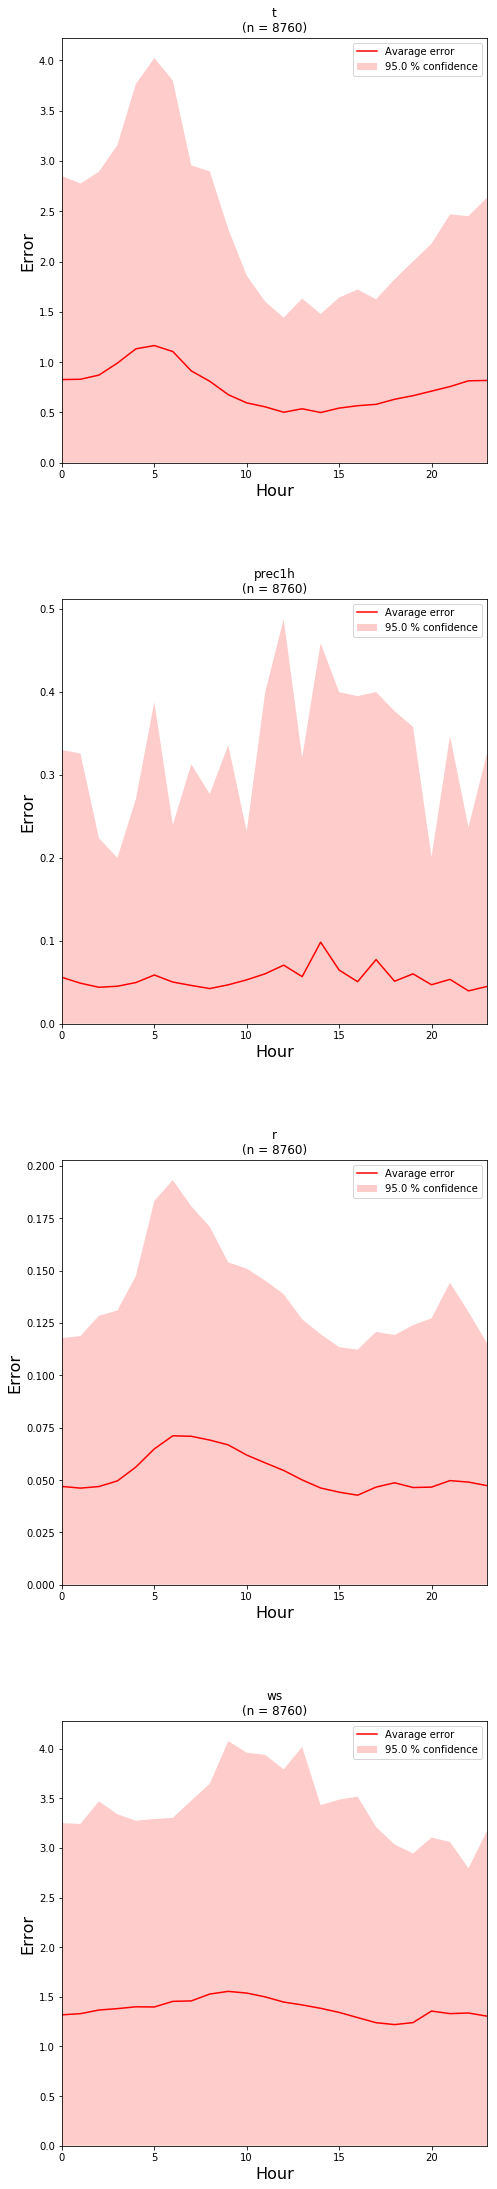

In [110]:
import matplotlib.pyplot as plt
import numpy as np

# === SETTINGS ======================================================================================
# conf: confidence of confidence interval.
conf = 0.95
# param_dict: Dictionary translating SMHI parameter names to corresponding parameters in reference.
#             Example: param_dict = {'t': 'ref_temperature', 'prec1h': 'ref_precipitation', ...}
param_dict = {'t': 'TM', 'prec1h': 'RR', 'r': 'UM', 'ws': 'FM2'}
# ===================================================================================================


# Construct error dataframe.
timestamps = df_MESAN['Timestamp']
tmp = {'Timestamp': timestamps}
for param in param_dict:
    tmp[param] = abs(df_MESAN[param] - df_REF[param_dict[param]])
df_ERROR = pd.DataFrame.from_dict(tmp)

ERROR_hours = divide_hours(df_ERROR)

N = len(param_dict)
hours = [i for i in range(0, 24)]
fig, axs = plt.subplots(N, 1, figsize=(8, 8*N))
fig.tight_layout(pad=6.0)
index = 0
for param in param_dict:
    
    conf_day_error = []
    avg_day_error = []
    for hour in hours:
        avg_day_error.append(ERROR_hours[hour][param].mean(skipna=True))
        tmp = np.sort(ERROR_hours[hour][param])
        elem = int(conf*ERROR_hours[hour][param].shape[0])
        conf_day_error.append(tmp[elem])
        
    
    axs[index].fill_between(hours, 0, conf_day_error, facecolor='r', alpha=0.2, label=str(conf*100) + ' % confidence')
    axs[index].plot(hours, avg_day_error, 'r', label='Avarage error')
    axs[index].legend()
    axs[index].set_xlabel('Hour', fontsize=16)
    axs[index].set_ylabel('Error', fontsize=16)
    
    axs[index].set_xlim([0, 23])
    axs[index].set_ylim([0, None])
    x0,x1 = axs[index].get_xlim()
    y0,y1 = axs[index].get_ylim()
    axs[index].set_aspect(abs(x1-x0)/abs(y1-y0))
    
    axs[index].title.set_text(param + '\n(n = ' + str(n) + ')')
    
    index = index + 1
    
    
    